# Anaylsis Bike Sharing Data

In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib as plt
%matplotlib inline
from sqlalchemy import create_engine
import requests
import time

import geopandas as gpd
from shapely.geometry import Point
from geopandas.tools import sjoin
import geoplot

# Analysis

This analysis uses the non-anonymised data to evaluate information on providers and unique bikes.

## Setup

In [17]:
df = pd.read_csv('../../data/cleaned.csv', parse_dates=['timestamp','end_timestamp', 'duration'])

In [39]:
df.duration = df.end_timestamp - df.timestamp

In [40]:
# day of the year
df['yday'] = df.timestamp.apply(lambda x: x.timetuple().tm_yday)

# hour of the day
df['dhour'] = df.timestamp.apply(lambda x: x.time().hour)

# "hour of the year"
df['yhour'] = df.dhour + (df.yday * 24)

# day of week
df['dweek'] = df.timestamp.apply(lambda x: x.weekday())

# "hour of the week"
df['whour'] = df.dhour + (df.dweek * 24)

# calendarweek
df['calweek'] = df.timestamp.apply(lambda x: x.isocalendar()[1])

In [6]:
# delete all trips from mobike
nomo = df[df.providerId != 2]

In [19]:
df.describe()

,id,id.1,bikeId,providerId,latitude,longitude,prev_id,next_id,prev_lat,prev_lon,...,distance,calc_time,duration,speed,yday,dhour,yhour,dweek,whour,calweek
count,5.300260e+05,5.300260e+05,5.300260e+05,530026.000000,530026.000000,530026.000000,5.300260e+05,5.300260e+05,530026.000000,530026.000000,...,530026.000000,530026.000000,530026,530026.000000,530026.000000,530026.000000,530026.000000,530026.000000,530026.000000,530026.000000
mean,1.779079e+06,1.779079e+06,3.751641e+08,1.281031,52.511071,13.385783,3.751641e+08,3.751641e+08,52.511046,13.385510,...,2427.326355,720.341570,0 days 02:13:04.810628,5.518721,141.045586,13.635186,3398.729260,2.955661,84.571042,20.727132
std,1.551575e+06,1.551575e+06,4.057313e+08,0.749341,0.019540,0.046768,4.057313e+08,4.057313e+08,0.019504,0.046971,...,2065.434001,570.087529,0 days 04:33:41.792505,5.725342,27.653907,5.744188,663.676298,1.978917,47.780873,3.949416
min,2.000000e+00,2.000000e+00,1.300100e+04,0.000000,52.360461,13.010897,1.300100e+04,1.300100e+04,52.360461,13.010897,...,200.100000,35.900000,0 days 00:02:34.203400,0.008346,91.000000,0.000000,2197.000000,0.000000,0.000000,14.000000
25%,4.849035e+05,4.849035e+05,1.754370e+05,1.000000,52.496990,13.347700,1.754370e+05,1.754370e+05,52.496933,13.347063,...,861.825000,285.600000,0 days 00:15:59.460606,0.925910,116.000000,9.000000,2789.000000,1.000000,42.000000,17.000000
50%,1.026545e+06,1.026545e+06,1.838900e+05,1.000000,52.510622,13.389274,1.838900e+05,1.838900e+05,52.510628,13.389121,...,1853.800000,565.200000,0 days 00:27:56.910572,4.237607,144.000000,14.000000,3466.000000,3.000000,86.000000,21.000000
75%,3.186866e+06,3.186866e+06,8.160239e+08,2.000000,52.524813,13.422601,8.160239e+08,8.160239e+08,52.524657,13.422580,...,3448.500000,1008.100000,0 days 01:15:53.780164,8.072169,164.000000,18.000000,3954.000000,5.000000,128.000000,24.000000
max,5.000193e+06,5.000193e+06,8.160550e+08,2.000000,52.683319,13.752372,8.160550e+08,8.160550e+08,52.683319,13.752372,...,34504.700000,9376.200000,0 days 23:59:59.988111,29.999916,192.000000,23.000000,4622.000000,6.000000,167.000000,28.000000


## How many unique bike IDs are there (per provider)?

### Unique ids over the entire time period

In [22]:
def get_unique_ids(df):
    unique_bikes = pd.DataFrame()
    unique_bikes = unique_bikes.append([([df.bikeId.unique().shape[0], df[(df.providerId == 0)].bikeId.unique().shape[0], 
             df[(df.providerId == 1)].bikeId.unique().shape[0],
             df[(df.providerId == 2)].bikeId.unique().shape[0]])])
    unique_bikes.columns = [['total', 'nextbike', 'lidlbike', 'mobike']]
    return unique_bikes

In [101]:
# cleaned dataet
get_unique_ids(df)

,total,nextbike,lidlbike,mobike
0,15040,2364,3534,9142


In [29]:
# not cleaned dataset
uniques = get_unique_ids(df)
uniques

,total,nextbike,lidlbike,mobike
0,15375,2396,3633,9346


### Daily available bikes

In [ ]:
# use dataset with information on "accessible" phases of bikes

In [113]:
# how many bikes are available each day?
def get_unique_ids_per_day(df):
    daily_unique = pd.DataFrame()

    start_time = df.sort_values('timestamp').reset_index().loc[0,'timestamp']
    end_time = df.sort_values('timestamp').reset_index().loc[df.shape[0]-2, 'timestamp']
    times= []
    
    # get all desired times
    while start_time < end_time:
        times.append(start_time)
        start_time += datetime.timedelta(hours=24)
    
    daily_unique['time'] = times
    daily_unique['total'] = daily_unique.time.apply(lambda x: df[
               (df.timestamp <= x) & 
               (df.end_timestamp >= x)].bikeId.unique().shape[0])
    daily_unique['nextbike'] = daily_unique.time.apply(lambda x: df[
               (df.providerId == 0)&
               (df.timestamp <= x) & 
               (df.end_timestamp >= x)].bikeId.unique().shape[0])
    daily_unique['lidlbike'] = daily_unique.time.apply(lambda x: df[
               (df.providerId == 1)&
               (df.timestamp <= x) & 
               (df.end_timestamp >= x)].bikeId.unique().shape[0])
    daily_unique['mobike'] = daily_unique.time.apply(lambda x: df[
               (df.providerId == 2)&
               (df.timestamp <= x) & 
               (df.end_timestamp >= x)].bikeId.unique().shape[0])
    
    return daily_unique
    

In [111]:
df_routed = pd.read_csv('../../data/routed.csv', parse_dates=['timestamp','end_timestamp'])

df_routed['duration'] = df_routed.end_timestamp - df_routed.timestamp

# drop trips that are longer than 24 hours
df_routed = df_routed.drop(df_routed[(df_routed['mode'] == 'trip') & (df_routed.duration > datetime.timedelta(hours=24))].index)

In [114]:
daily_uniques = get_unique_ids_per_day(df_routed)

In [115]:
daily_uniques.describe()

,total,nextbike,lidlbike,mobike
count,106.000000,106.000000,106.000000,106.000000
mean,6648.952830,1080.386792,2378.132075,3190.433962
std,1683.276037,225.138754,984.323999,1105.881644
min,603.000000,0.000000,0.000000,16.000000
25%,5265.500000,1007.500000,2642.250000,3410.250000
50%,7449.000000,1095.500000,2813.000000,3533.500000
75%,7719.750000,1215.750000,2889.000000,3730.000000
max,8078.000000,1409.000000,3048.000000,3966.000000


In [261]:
available_nextbike = daily_uniques.describe().nextbike.loc['50%']
available_lidlbike = daily_uniques.describe().lidlbike.loc['50%']
available_total = daily_uniques.describe().total.loc['50%']

## Distance

In [90]:
## sum of kilometers driven each day

In [294]:
df.groupby(['providerId', 'yday']).sum().distance.describe()

count    1.020000e+02
mean     8.181863e+06
std      3.060360e+06
min      1.554133e+06
25%      6.624518e+06
50%      8.730289e+06
75%      1.034454e+07
max      1.409361e+07
Name: distance, dtype: float64

In [295]:
## average distance

In [296]:
nomo.distance.describe()

count    285505.000000
mean       2923.066337
std        2068.878080
min         300.100000
25%        1392.400000
50%        2416.400000
75%        3990.900000
max       34504.700000
Name: distance, dtype: float64

In [297]:
# average distance per provider

In [298]:
df.groupby('providerId').distance.describe()

,count,mean,std,min,25%,50%,75%,max
providerId,,,,,,,,
0,96060.0,3181.509189,2302.334391,300.2,1491.5,2651.25,4328.200,34504.7
1,192576.0,2772.546322,1930.933922,300.1,1327.9,2284.90,3793.325,18159.2
2,221595.0,2185.121588,1946.801769,300.1,740.5,1562.30,2993.500,13909.0


## Duration

In [305]:
trips.duration.describe()

count                    285505
mean     0 days 01:37:44.060788
std      0 days 03:57:21.167035
min      0 days 00:03:08.838554
25%      0 days 00:15:59.737327
50%      0 days 00:23:59.672760
75%      0 days 00:40:00.278078
max      0 days 23:59:59.988111
Name: duration, dtype: object

In [306]:
trips.groupby('providerId').duration.describe()

,count,mean,std,min,25%,50%,75%,max
providerId,,,,,,,,
0,95594,0 days 03:24:06.610921,0 days 05:54:10.698723,0 days 00:03:08.838554,0 days 00:16:00.942989,0 days 00:31:59.754681,0 days 02:56:00.061008,0 days 23:59:59.988111
1,189911,0 days 00:44:11.326942,0 days 01:53:57.996358,0 days 00:03:32.949500,0 days 00:15:59.375762,0 days 00:20:00.649095,0 days 00:32:00.097121,0 days 23:59:59.786224


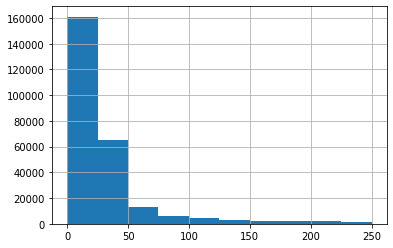

In [307]:
# histogram of minutes spent on trip
trips.duration.apply(lambda x: x.seconds / 60).hist(range=(0,250))

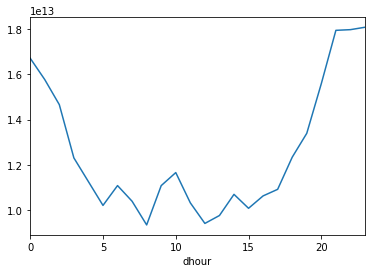

In [308]:
trips[trips.providerId == 0].groupby('dhour').duration.describe()['mean'].plot()

## daily counts of trips

In [310]:
# daily trips by provider
df.groupby(['yday', 'providerId']).count().id.groupby('providerId').describe()

providerId
0    2678.288660
1    5139.977778
Name: id, dtype: float64

## count of trips each hour

In [311]:
counts = trips[['bikeId', 'yhour']].groupby(['yhour']).count()

In [314]:
nb = trips[trips.providerId == 0][['bikeId', 'yhour']].groupby(['yhour']).count()

lb = trips[trips.providerId == 1][['bikeId', 'yhour']].groupby(['yhour']).count()

# mb = trips[trips.providerId == 2][['bikeId', 'yhour']].groupby(['yhour']).count()

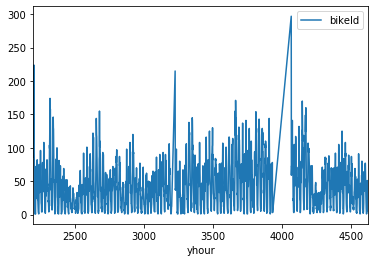

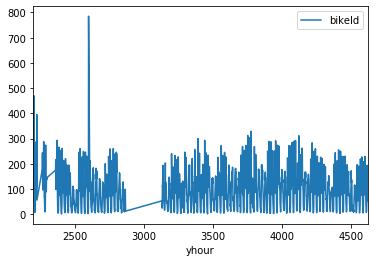

In [315]:
nb.plot()
lb.plot()
# mb.plot()

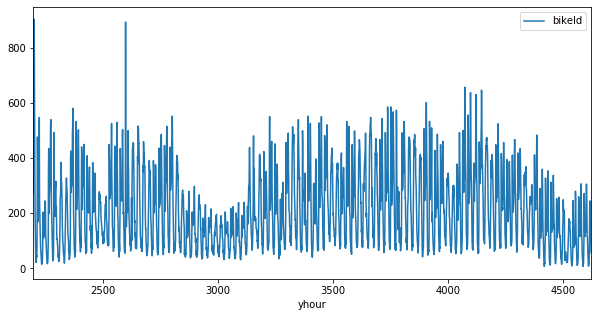

In [65]:
counts.plot(figsize=(10,5))

#### How much time is a bike used? 

In [87]:
# average trips per bike
trips.groupby(['bikeId', 'providerId']).count().id.groupby('providerId').describe()

,count,mean,std,min,25%,50%,75%,max
providerId,,,,,,,,
0,2365.0,42.797040,16.472283,1.0,33.0,43.0,53.0,191.0
1,3551.0,59.564066,26.760414,1.0,42.0,62.0,79.0,161.0
2,9186.0,37.920422,69.884386,1.0,17.0,30.0,45.0,1823.0


## how high is the utilization rate? (available bikes / all bikes)

In [129]:
## more precise, than general average of available bikes
#
# all accessibe bikes each day
# accessible = df.drop_duplicates(subset = ['yday', 'bikeId', 'providerId']).groupby(['yday', 'providerId']).count()

# merge df on accessible bikes per day
# in_use = in_use['id'].reset_index().set_index(['yday', 'providerId', 'dhour']).join(accessible['id.1'].reset_index().set_index(['yday', 'providerId']))
# in_use.rename(columns={"id": "in_use", "id.1": "accessible"}, inplace=True)

In [36]:
# how many bikes are available / on a trip for each hour?
def count_bikes_in_mode(df, mode):
    bikes_accessible = pd.DataFrame()

    start_time = df.sort_values('timestamp').reset_index().loc[0,'timestamp']
    end_time = df.sort_values('timestamp').reset_index().loc[df.shape[0]-2, 'timestamp']
    times= []
    while start_time < end_time:
        times.append(start_time)
        start_time += datetime.timedelta(hours=1)
    
    bikes_accessible['time'] = times
    bikes_accessible['total'] = bikes_accessible.time.apply(lambda x: df[(df['mode']==mode) &
               (df.timestamp <= x) & 
               (df.end_timestamp > x)].bikeId.unique().shape[0])
    bikes_accessible['nextbike'] = bikes_accessible.time.apply(lambda x: df[(df['mode']==mode) &
               (df.providerId == 0) &
               (df.timestamp <= x) & 
               (df.end_timestamp > x)].bikeId.unique().shape[0])
    bikes_accessible['lidlbike'] = bikes_accessible.time.apply(lambda x: df[(df['mode']==mode) &
               (df.providerId == 1) &
               (df.timestamp <= x) & 
               (df.end_timestamp > x)].bikeId.unique().shape[0])
   # bikes_accessible['mobike'] = bikes_accessible.time.apply(lambda x: df[(df['mode']==mode) &
    #           (df.providerId == 2)&
     #          (df.timestamp <= x) & 
      #         (df.end_timestamp > x)].bikeId.unique().shape[0])
    
    # day of the year
    bikes_accessible['yday'] = bikes_accessible.time.apply(lambda x: x.timetuple().tm_yday)

    # hour of the day
    bikes_accessible['dhour'] = bikes_accessible.time.apply(lambda x: x.time().hour)

    # "hour of the year"
    bikes_accessible['yhour'] = bikes_accessible.dhour + (bikes_accessible.yday * 24)

    # day of week
    bikes_accessible['dweek'] = bikes_accessible.time.apply(lambda x: x.weekday())
    return bikes_accessible

In [37]:
in_use = count_bikes_in_mode(df[(df.timestamp > datetime.datetime(2019,6,1)) & (df.timestamp < datetime.datetime(2019,7,1))].sort_values('timestamp'), 'trip')

In [222]:
in_use['nextbike'] = in_use.nextbike / available_nextbike
in_use['lidlbike'] = in_use.lidlbike / available_lidlbike
in_use['total'] = in_use.total / available_total

In [223]:
# in_use.groupby('dhour').mean()

In [230]:
in_use.describe()

,total,nextbike,lidlbike,yday,dhour,yhour,dweek
count,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000
mean,0.032488,0.141295,0.026134,166.500000,11.500000,4007.500000,3.166667
std,0.015736,0.084439,0.016040,8.661458,6.926999,207.990384,2.035840
min,0.000881,0.000000,0.000000,152.000000,0.000000,3648.000000,0.000000
25%,0.021888,0.081488,0.011382,159.000000,5.750000,3827.750000,1.000000
50%,0.033713,0.164861,0.024601,166.500000,11.500000,4007.500000,3.000000
75%,0.043188,0.205370,0.037452,174.000000,17.250000,4187.250000,5.000000
max,0.072126,0.300518,0.073435,181.000000,23.000000,4367.000000,6.000000


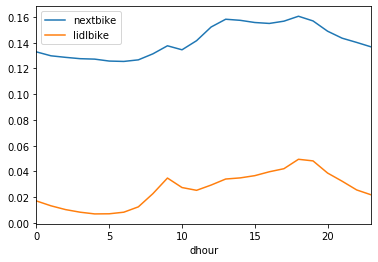

In [224]:
in_use.groupby('dhour').mean()[['nextbike', 'lidlbike']].plot()

Usage rate varies between 0 and 16 %.

#### how many bikes bikes are accessible / in use each day?

In [269]:
# on average accessible bikes per day
df.drop_duplicates(subset = ['yday', 'bikeId', 'providerId']).groupby(['yday', 'providerId']).count().groupby('providerId').median()

,id,id.1,bikeId,timestamp,latitude,longitude,prev_id,next_id,prev_lat,prev_lon,...,response,geometry,distance,calc_time,waypoints,duration,speed,dhour,yhour,dweek
providerId,,,,,,,,,,,,,,,,,,,,,
0,953,953,953,953,953,953,953,953,953,953,...,360,360,360,360,360,953,360,953,953,953
1,2326,2326,2326,2326,2326,2326,2326,2326,2326,2326,...,497,497,497,497,497,2326,497,2326,2326,2326
2,4373,4373,4373,4373,4373,4373,4373,4373,4373,4373,...,161,161,161,161,161,4373,161,4373,4373,4373


In [43]:
# on average used bikes per day
df.drop_duplicates(subset = ['yday', 'bikeId', 'providerId']).groupby(['yday', 'providerId']).count().groupby('providerId').describe().id

,count,mean,std,min,25%,50%,75%,max
providerId,,,,,,,,
0,97.0,581.597938,182.938609,51.0,458.0,593.0,724.0,965.0
1,89.0,1134.943820,206.258684,214.0,1057.0,1147.0,1266.0,1472.0
2,95.0,1336.147368,324.755291,1.0,1225.0,1380.0,1528.0,1764.0


In [44]:
# on overage used bikes per hour
df.groupby(['providerId', 'yhour']).count().groupby('providerId').describe().id

,count,mean,std,min,25%,50%,75%,max
providerId,,,,,,,,
0,2155.0,44.204640,35.060875,1.0,16.0,38.0,64.0,296.0
1,1968.0,96.824187,70.588359,1.0,36.0,90.0,138.0,807.0
2,2116.0,115.413516,43.647953,1.0,82.0,112.0,147.0,256.0


In [272]:
# percentage of bikes used daily
df.drop_duplicates(subset = ['yday', 'bikeId', 'providerId']).groupby('yday').count().median().id / available_total

0.45023822128110114

## How many rides per bike per day?

In [46]:
df.groupby(['yday', 'bikeId', 'providerId']).count().groupby('providerId').describe().id

,count,mean,std,min,25%,50%,75%,max
providerId,,,,,,,,
0,56415.0,1.688576,1.151787,1.0,1.0,1.0,2.0,61.0
1,101010.0,1.886447,1.123010,1.0,1.0,2.0,2.0,12.0
2,126934.0,1.923953,3.903933,1.0,1.0,1.0,2.0,115.0


Median of 1-2 rides per bike per day.

In [51]:
df.groupby(['yday', 'bikeId']).count().id.describe()

count    284359.000000
mean          1.863933
std           2.742675
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         115.000000
Name: id, dtype: float64

#### Bike Availability: 
- Where are bikes available (per Planungsraum)? On average? On average weekdays / times?
- Distance between available bikes

#### how long is the life span of a bike? (first appearence and last appearence)
- is there periodical appearences?

In [259]:
# get data for lifespan

def lifespan (df):
    # each line one trip with start-loc and end-loc
    # for each bike ID
    start_timestamp = df.sort_values(by=['bikeId', 'timestamp']).drop_duplicates('bikeId', keep='first')
    last_timestamp = df.sort_values(by=['bikeId', 'timestamp'], ascending = False).drop_duplicates('bikeId', keep='first')
    start_timestamp.set_index('bikeId', inplace=True)
    last_timestamp.set_index('bikeId', inplace=True)
    return start_timestamp.join(last_timestamp[['timestamp']], rsuffix='_last')

In [261]:
lifespan = lifespan(df)

In [268]:
(lifespan.timestamp_last - lifespan.timestamp).median()

Timedelta('88 days 06:09:59.964870')

#### speed of bikes

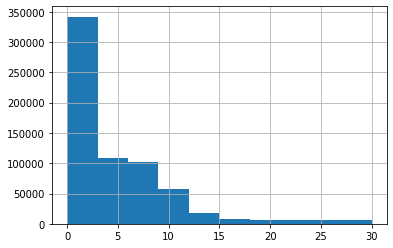

In [271]:
df['speed'].hist()

In [272]:
df['speed'].describe()

count    661064.000000
mean          4.711225
std           5.547541
min           0.004344
25%           0.526149
50%           2.731577
75%           7.240797
max          29.999916
Name: speed, dtype: float64